In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Imports

In [2]:
from fastai.vision.all import *
import torchvision.transforms as torchtransforms
from tqdm.notebook import tqdm
from exp.plot_utils import *
import torch

# Approach

We will use a neural network to visualise parameter spaces between different types of objects in the real world.

To keep it simple, lets look at two common objects found in outdoor spaces:

- A Bicycle
- A Tree

The Convolutional Neural Network (CNN) should be able to provide different parameters based on how it "sees" these objects. The goal of this experiment is to establish the fact that different vision targets will have different parameter spaces and these spaces are mutually seprated from each other for the given vision target. Same kind of categories (like all Cycles) will have similar parameter spaces, but these spaces will be very different from the ones used by parameter spaces of Trees.

# The Data

As a first step, we would create some data using the `duckduckgo_search` utility.

In [3]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=200): return L(ddg_images(term, max_results=max_images)).itemgot('image')

[FastAI Source](https://github.com/fastai/course22/blob/master/00-is-it-a-bird-creating-a-model-from-your-own-data.ipynb)

#### Check that the function works

Cycles:

In [4]:
urls = search_images('bicycle photos', max_images=1)
urls[0]

'https://i5.walmartimages.com/asr/20128ae8-b8ae-4022-a191-34f36fe64e93_1.8999c2eeee938adf859f373aa20057ad.jpeg'

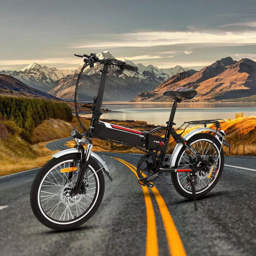

In [5]:
from fastdownload import download_url
dest = 'bicycle.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Trees:

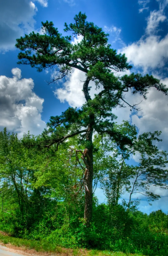

In [6]:
download_url(search_images('tree photos', max_images=1)[0], 'tree.jpg', show_progress=False)
Image.open('tree.jpg').to_thumb(256,256)

#### Download Data for both categories

In [7]:
searches = 'bicycle','tree'
path = Path('bicycle_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} morning photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} evening photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Use FastAI's utility to clean-up bad images that were not downloaded properly.

In [8]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

20

#### Create FastAI Data Blocks to train the network

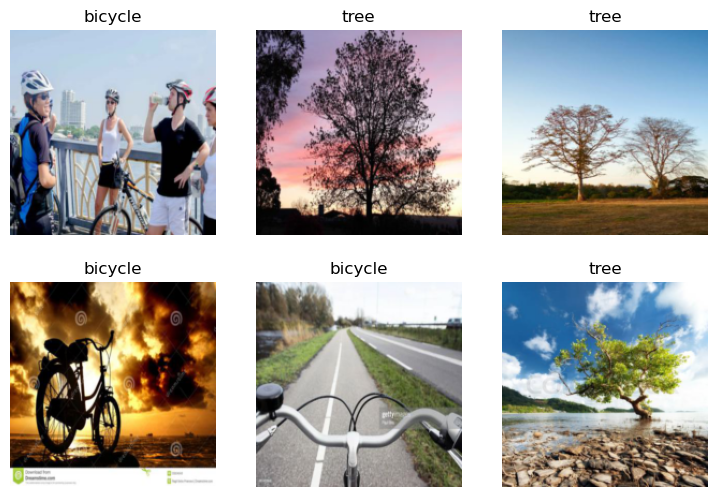

In [43]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

Alright, we are all set to train our model.

# The CNN

We use `fast.ai` library to get access to popular Convolutional Neural Network architectures. The one we would use for this experiment is the `Resnet` architecture. More specifically, we are using the `Resnet 18` variant of that architecture, which is generally good enough for quick experiments. 

In [10]:
learn = vision_learner(dls, resnet18, metrics=accuracy)

/home/gaurav/anaconda3/envs/fastai-generic/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/gaurav/anaconda3/envs/fastai-generic/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
learn.fine_tune(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.586208,0.089625,0.982379,00:03


epoch,train_loss,valid_loss,accuracy,time
0,0.123366,0.147687,0.933921,00:03
1,0.078243,0.038900,0.986784,00:03
2,0.049389,0.032508,0.991189,00:03


This small Resnet18 is more than 97% accurate in predicting these two classes. 

In practice, with good data engineering, careful hyperparameter tuning and training proceduces, we can achieve accuracies of over 99%.

#### Check if the network can correctly predict what it sees

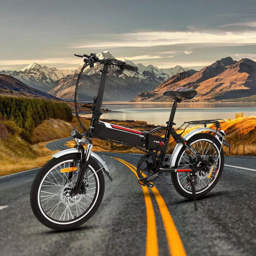

In [12]:
im.to_thumb(256,256)

In [13]:
is_bicycle,_,probs = learn.predict(PILImage.create('bicycle.jpg'))
print(f"This is a: {is_bicycle}.")
print(f"Probability it's a bicycle: {probs[0]:.4f}")

This is a: bicycle.
Probability it's a bicycle: 0.9999


The CNN is 100% sure that this is a bicycle.

 # Parameter Spaces

Most neural networks create an output based on the final list of categories that they are trained on. This information is stored as high ranked tensor data structures, often called as **embeddings**.

An embedding can be understood as a collection of visual properties that an object's physical appearance holds. Meaning - that all bicycles will have embeddings that will capture how a bicycle looks. Similarly, embeddings for trees will hold information on how trees look. Both these embeddings will be seprated in high-dimentional parameter spaces. Let us now try to visualize these spaces for this example.

PS: The process of seprating objects based on physical, visual properties is also commonly referred to as **Clustering**.

#### Get the network that was used in training above

In [14]:
cnn = learn.model
cnn

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

The final four layers of this Neural Network are simply used to make the  prediction between a Bicycle and a Tree. The embedding is captured as the `out_features` variable that comes out of the penultimate `nn.Linear` layer. Lets try to create a sub-network by removing the final four layers.

In [15]:
temp = nn.Sequential(*list(cnn.children())[-1])
temp

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=512, out_features=2, bias=False)
)

In [16]:
temp2 = nn.Sequential(*list(temp.children())[:-4])
temp2

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): fastai.layers.Flatten(full=False)
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=1024, out_features=512, bias=False)
)

In [17]:
cnn[-1] = temp2

In [18]:
cnn

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

#### Gather embeddings for our data samples

In [29]:
def emb_one(file, model):
    model.eval()
    tfms = torchtransforms.Compose([torchtransforms.Resize(192),
                                    torchtransforms.ToTensor(),
                                    torchtransforms.Normalize(
                                        [0.485, 0.456, 0.406],
                                        [0.229, 0.224, 0.225])])
    if isinstance(file, Path):
        img = PILImage.create(file)
    elif isinstance(file, PILImage):
        img = file
    else: raise Exception("Input file should be either a Path or PILImage object.")
    
    x = tfms(img).unsqueeze(0)
    #x = x.cuda()
    with torch.no_grad():
        emb = model(x)
    return emb

In [31]:
cnn = cnn.cpu()

In [32]:
out_single = emb_one(Path('bicycle.jpg'), cnn)

In [33]:
out_single.size()


torch.Size([1, 512])

In [34]:
out_single

TensorBase([[ 0.5072, -1.4599, -0.7048,  2.1189,  2.4037, -3.2266, -1.7642,
             -3.4515, -0.1919, -2.3978,  1.7465,  1.5617, -0.2913, -2.0878,
             -2.6482, -2.7042, -0.5945, -0.4605, -0.1350, -2.9368, -1.7413,
             -3.1794, -0.3149, -0.2107, -2.2381, -0.6281,  1.2016, -3.3141,
              1.1496,  0.2040, -1.5373, -2.5681, -1.3348, -1.8191, -0.9473,
             -0.0061, -1.7965, -4.5111,  0.9574, -1.1925, -0.9566, -0.9220,
             -4.0463, -2.2650, -2.3350,  1.1909, -3.0154,  0.9281,  3.0688,
              0.0646,  1.6119,  0.1781,  1.2393,  2.5830, -1.8323, -2.5970,
             -1.9880,  2.2942,  0.9060,  0.6523, -2.1497,  2.0217, -1.3053,
              0.6832,  0.4428,  0.6794,  0.6393,  0.2083, -1.8576, -1.1134,
              1.1930, -0.2721, -0.2073, -1.1240, -0.6850,  1.9998,  0.3192,
              0.3497, -3.3212,  0.5130, -0.4086, -0.7236,  0.5153, -1.7542,
             -1.4764, -2.8089, -1.4792,  1.4510,  1.8814,  1.0692,  0.3098,
            

As discussed earlier, these parameters represent the physical representation of a cycle sample picture. Now lets try to create a function that can generate multiple embeddings for our input files.

In [35]:
def emb_multi(files, model):
    "Get embeddings for all items in files"
    labels = None
    embeddings = None
    for i in tqdm(range(len(files))):
        # Collect label
        file = files[i]
        label_str = parent_label(file)
        label = 0 if label_str == 'bicycle' else 1
        label_tensor = torch.tensor(int(label)).unsqueeze(0)
        if labels is None:
            labels = label_tensor
        else:
            labels = torch.cat((labels, label_tensor), dim=0)
        # Collect embedding
        emb = emb_one(file, model)
        if embeddings is None : 
            embeddings = emb
        else:
            embeddings = torch.cat((embeddings, emb), dim=0)
        sleep(0.01)
    return labels, embeddings

In [36]:
all_imgs = get_image_files(path)

In [40]:
sub_emb = emb_multi(all_imgs, cnn)

  0%|          | 0/1138 [00:00<?, ?it/s]

In [41]:
al, ae = sub_emb

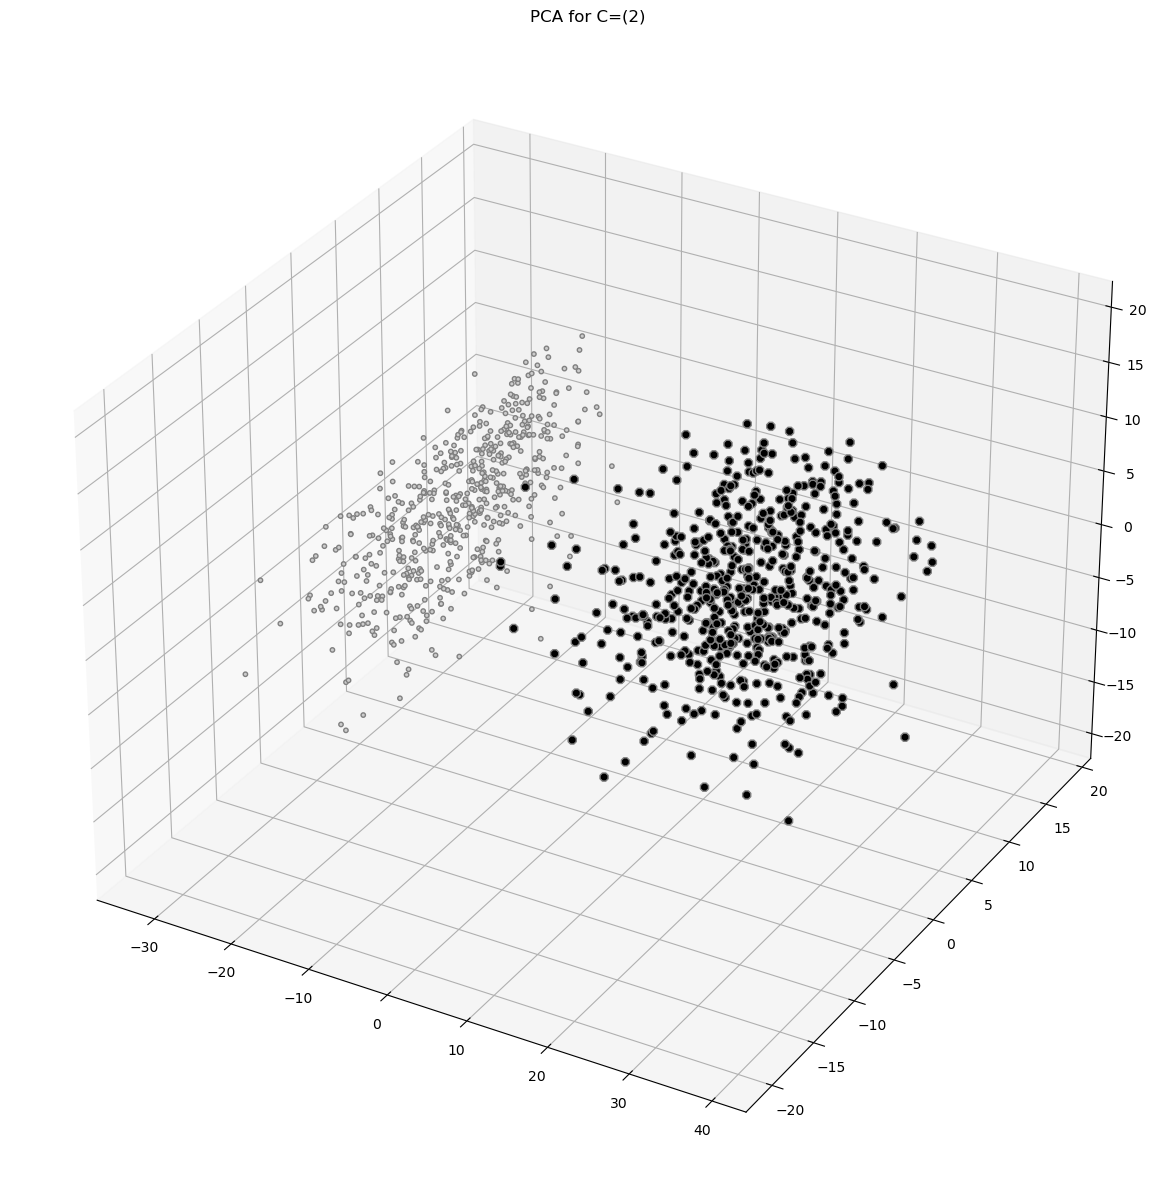

In [42]:
pca_fig = plot_pca(al, ae, figsize=[15, 15])

In [ ]:
torch.me